<a href="https://colab.research.google.com/github/Subi004/python-project-1/blob/main/helmet%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# install packages used in YOLO model
! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 41.9 MB/s eta 0:00:00


In [ ]:
# check model
import ultralytics
ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.3/107.7 GB disk)


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
from itertools import chain
from collections import Counter
from pprint import pprint

id2class_map = {
    '0': 'with helmet',
    '1': 'without helmet',
    '2': 'rider',
    '3': 'number_plate'
}
main_path = "/content/drive/MyDrive/bike_helmet_detection_dataset"
def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')

def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()
print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')

train data count: 104
-- data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 20
-- data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 23,
 '3. number_plate': 22}



In [ ]:
# plot training images
import os
import cv2
from matplotlib import pyplot as plt

main_path = f"/content/drive/MyDrive/bike_helmet_detection_dataset"

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    ''' get bbox and label information from label txt files '''

    # read file from path
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()

    # extract bboxes and labels from the label file
    bboxes = [
        [float(n) for n in line.split()[1:]]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]

    return bboxes, labels

def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924

    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox

    # calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2

    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)

    return x_min, y_min, x_max, y_max

class2color_map = {
    'with helmet': (0,255,128),
    'without helmet': (255,51,51),
    'rider': (51,255,255),
    'number_plate': (224,102,255)
}

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):

        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

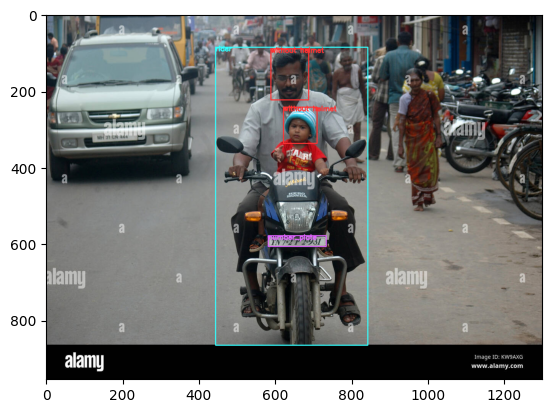

In [ ]:
plot_image(image_name='new100')

In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Display model information (optional)
model.info()

100%|██████████| 6.25M/6.25M [00:00<00:00, 117MB/s]


YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [ ]:
import yaml

# read the content of coco128.yaml
with open(os.path.join(main_path, 'coco128.yaml'), 'r') as file:
    print(file.read())

train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]


In [ ]:
# creata the yaml based on coco128 for model training
data = {
    'train': '/content/drive/MyDrive/bike_helmet_detection_dataset/train',
    'val': '/content/drive/MyDrive/bike_helmet_detection_dataset/val',
    'nc': 4,
    'names': [
        'with helmet',
        'without helmet',
        'rider',
        'number plate'
    ]
}

with open('/content/drive/MyDrive/bike_helmet_detection_dataset/coco128.yaml', 'w') as file:
    yaml.dump(data, file)

# check the content of data.yaml
with open('/content/drive/MyDrive/bike_helmet_detection_dataset/coco128.yaml', 'r') as file:
    print(file.read())

names:
- with helmet
- without helmet
- rider
- number plate
nc: 4
train: /content/drive/MyDrive/bike_helmet_detection_dataset/train
val: /content/drive/MyDrive/bike_helmet_detection_dataset/val



In [ ]:
# disable wandb
os.environ['WANDB_MODE'] = "disabled"


# command to train the YOLOv8 model
model.train(
    data='/content/drive/MyDrive/bike_helmet_detection_dataset/coco128.yaml',
    epochs=50,
    workers=1,
    batch=8,
)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/bike_helmet_detection_dataset/coco128.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 755k/755k [00:00<00:00, 101MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/bike_helmet_detection_dataset/train/labels... 102 images, 0 backgrounds, 2 corrupt: 100%|██████████| 104/104 [00:04<00:00, 20.94it/s]

train: WARNING ⚠️ /content/drive/MyDrive/bike_helmet_detection_dataset/train/images/new128.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/bike_helmet_detection_dataset/train/images/new128.jpg'
train: WARNING ⚠️ /content/drive/MyDrive/bike_helmet_detection_dataset/train/images/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'heic', 'tif', 'dng', 'png', 'tiff', 'jpeg', 'webp', 'mpo', 'pfm', 'bmp', 'jpg'}
videos: {'mkv', 'gif', 'avi', 'mpeg', 'mp4', 'asf', 'mpg', 'm4v', 'webm', 'ts', 'wmv', 'mov'}


train: New cache created: /content/drive/MyDrive/bike_helmet_detection_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/bike_helmet_detection_dataset/val/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]

val: New cache created: /content/drive/MyDrive/bike_helmet_detection_dataset/val/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.054      3.434      1.283         67        640: 100%|██████████| 13/13 [01:44<00:00,  8.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.52s/it]

                   all         20         73     0.0157      0.399      0.188       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G     0.9362      2.377       1.15         39        640: 100%|██████████| 13/13 [01:40<00:00,  7.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.55s/it]

                   all         20         73     0.0236      0.408      0.186      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G     0.9025      1.597      1.152         40        640: 100%|██████████| 13/13 [01:36<00:00,  7.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.59s/it]

                   all         20         73      0.945      0.217      0.674      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G     0.9266      1.367      1.094         73        640: 100%|██████████| 13/13 [01:38<00:00,  7.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]

                   all         20         73      0.906      0.357      0.741      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.8841      1.231      1.074         28        640: 100%|██████████| 13/13 [01:37<00:00,  7.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]

                   all         20         73      0.677      0.455       0.76      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.8564      1.154      1.063         42        640: 100%|██████████| 13/13 [01:37<00:00,  7.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.96s/it]

                   all         20         73      0.674      0.554      0.697      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.8326      1.124      1.051         43        640: 100%|██████████| 13/13 [01:35<00:00,  7.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.33s/it]

                   all         20         73      0.753      0.614      0.779      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G     0.8451      1.152      1.076         36        640: 100%|██████████| 13/13 [01:36<00:00,  7.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]

                   all         20         73      0.792      0.571       0.78      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G     0.8255       1.07      1.071         35        640: 100%|██████████| 13/13 [01:35<00:00,  7.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.65s/it]

                   all         20         73      0.827      0.644      0.843      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G     0.8342      1.005      1.044         38        640: 100%|██████████| 13/13 [01:34<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]

                   all         20         73      0.798      0.696      0.827      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G     0.8813      1.058      1.108         51        640: 100%|██████████| 13/13 [01:36<00:00,  7.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]

                   all         20         73      0.754      0.697      0.811      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G     0.7713     0.9598      1.042         50        640: 100%|██████████| 13/13 [01:35<00:00,  7.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         20         73      0.852      0.826      0.909        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.7966     0.9296      1.034         58        640: 100%|██████████| 13/13 [01:36<00:00,  7.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]

                   all         20         73      0.909      0.843      0.928      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.7857     0.9145      1.019         61        640: 100%|██████████| 13/13 [01:35<00:00,  7.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]

                   all         20         73      0.844      0.855      0.924      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G     0.7956     0.8975      1.029         55        640: 100%|██████████| 13/13 [01:34<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]

                   all         20         73      0.808      0.885      0.917      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.7626     0.8757      1.042         45        640: 100%|██████████| 13/13 [01:34<00:00,  7.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.49s/it]

                   all         20         73      0.856      0.869      0.922      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.7445     0.8243      1.007         57        640: 100%|██████████| 13/13 [01:33<00:00,  7.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]

                   all         20         73       0.91      0.898      0.925      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.7412      0.846      1.019         36        640: 100%|██████████| 13/13 [01:34<00:00,  7.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.77s/it]

                   all         20         73      0.914        0.9      0.933      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.7506     0.8598      1.035         44        640: 100%|██████████| 13/13 [01:35<00:00,  7.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         20         73      0.902       0.89      0.924      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.7212     0.7952       1.01         35        640: 100%|██████████| 13/13 [01:35<00:00,  7.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.90s/it]

                   all         20         73      0.878      0.904      0.923      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.6809     0.7595     0.9708         52        640: 100%|██████████| 13/13 [01:34<00:00,  7.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         20         73      0.881        0.9      0.923      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.7002      0.786     0.9925         41        640: 100%|██████████| 13/13 [01:36<00:00,  7.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.06s/it]

                   all         20         73      0.901      0.886      0.934      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.6663     0.7289     0.9627         51        640: 100%|██████████| 13/13 [01:35<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]

                   all         20         73      0.918      0.905       0.94      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.6536     0.7404     0.9649         49        640: 100%|██████████| 13/13 [01:36<00:00,  7.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]

                   all         20         73      0.919      0.903      0.944      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.6426     0.7192     0.9828         46        640: 100%|██████████| 13/13 [01:35<00:00,  7.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]

                   all         20         73       0.93      0.906      0.952      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.6377     0.7384     0.9823         48        640: 100%|██████████| 13/13 [01:35<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.46s/it]

                   all         20         73      0.902      0.913      0.954      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.6497     0.7201     0.9897         31        640: 100%|██████████| 13/13 [01:35<00:00,  7.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.52s/it]

                   all         20         73      0.934      0.921      0.943      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.6277     0.6789     0.9467         43        640: 100%|██████████| 13/13 [01:33<00:00,  7.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.18s/it]

                   all         20         73      0.901      0.939      0.945      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.6237     0.6767     0.9711         56        640: 100%|██████████| 13/13 [01:34<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]

                   all         20         73      0.878      0.943      0.941      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.6317     0.6457     0.9558         35        640: 100%|██████████| 13/13 [01:34<00:00,  7.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]

                   all         20         73       0.87      0.944      0.953      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.5975     0.6485      0.935         40        640: 100%|██████████| 13/13 [01:34<00:00,  7.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]

                   all         20         73      0.919       0.91      0.944      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.6106     0.6363     0.9652         41        640: 100%|██████████| 13/13 [01:35<00:00,  7.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]

                   all         20         73      0.905      0.948      0.942       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.6268      0.667     0.9568         56        640: 100%|██████████| 13/13 [01:35<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.52s/it]

                   all         20         73      0.913      0.946      0.944      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.5885     0.6392      0.951         40        640: 100%|██████████| 13/13 [01:36<00:00,  7.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]

                   all         20         73      0.936      0.925      0.952      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.5899     0.6204     0.9459         47        640: 100%|██████████| 13/13 [01:35<00:00,  7.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.93s/it]

                   all         20         73      0.905      0.927      0.944      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      0.613     0.6276     0.9754         36        640: 100%|██████████| 13/13 [01:34<00:00,  7.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.25s/it]

                   all         20         73      0.894      0.952      0.946      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.6084     0.6119     0.9587         44        640: 100%|██████████| 13/13 [01:34<00:00,  7.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.63s/it]

                   all         20         73      0.906      0.951      0.949      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.5944     0.6155     0.9591         48        640: 100%|██████████| 13/13 [01:35<00:00,  7.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.50s/it]

                   all         20         73      0.899      0.951      0.948       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.5929     0.6043      0.944         42        640: 100%|██████████| 13/13 [01:35<00:00,  7.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]

                   all         20         73      0.912      0.938      0.952      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.6027     0.6075     0.9677         45        640: 100%|██████████| 13/13 [01:33<00:00,  7.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.64s/it]

                   all         20         73      0.913       0.94      0.961      0.793


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.5497     0.7898     0.9406         19        640: 100%|██████████| 13/13 [01:33<00:00,  7.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]

                   all         20         73      0.863      0.972      0.956      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.5251      0.725     0.8779         20        640: 100%|██████████| 13/13 [01:34<00:00,  7.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]

                   all         20         73      0.876      0.967      0.956      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.5148     0.6913     0.8869         22        640: 100%|██████████| 13/13 [01:33<00:00,  7.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.50s/it]

                   all         20         73      0.885      0.965      0.946      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.5308     0.6809     0.8787         19        640: 100%|██████████| 13/13 [01:34<00:00,  7.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]

                   all         20         73       0.92      0.889      0.941      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.4903     0.6308     0.8779         21        640: 100%|██████████| 13/13 [01:33<00:00,  7.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.58s/it]

                   all         20         73      0.931      0.887      0.939      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.4984     0.6377     0.8678         30        640: 100%|██████████| 13/13 [01:34<00:00,  7.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.14s/it]

                   all         20         73       0.92      0.895      0.933      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.4925     0.6137     0.8719         24        640: 100%|██████████| 13/13 [01:35<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.55s/it]

                   all         20         73       0.92      0.895      0.933      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.5119     0.6336     0.8698         24        640: 100%|██████████| 13/13 [01:33<00:00,  7.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]

                   all         20         73      0.918      0.895      0.934      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.5135     0.6395     0.9015         27        640: 100%|██████████| 13/13 [01:36<00:00,  7.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]

                   all         20         73      0.905      0.933      0.943      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.4952     0.6131     0.8656         22        640: 100%|██████████| 13/13 [01:34<00:00,  7.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]

                   all         20         73      0.901      0.934      0.945      0.777



50 epochs completed in 1.436 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]


                   all         20         73      0.912       0.94      0.961      0.793
           with helmet         12         13      0.913      0.923       0.94      0.756
        without helmet         10         15      0.822      0.924       0.92      0.733
                 rider         20         23      0.914      0.919      0.989      0.904
          number plate         20         22          1      0.995      0.995      0.779
Speed: 3.7ms preprocess, 284.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c59455d9a80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
# select the best model for checking prediction plot
# the model is saved in best.pt directly after training
model = YOLO('/content/runs/detect/train2/weights/best.pt')

In [ ]:
# use results from `model.predict()` for plotting
def plot_pred_image(image_name, id2class_map=id2class_map, class2color_map=class2color_map):
    image_path = os.path.join(main_path, 'val', 'images', f'{image_name}.jpg')

    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]
    for bbox, label in zip(bboxes, labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

prediction ↓

image 1/1 /content/drive/MyDrive/bike_helmet_detection_dataset/val/images/new94.jpg: 608x640 1 with helmet, 1 rider, 1 number plate, 288.9ms
Speed: 8.1ms preprocess, 288.9ms inference, 6.0ms postprocess per image at shape (1, 3, 608, 640)


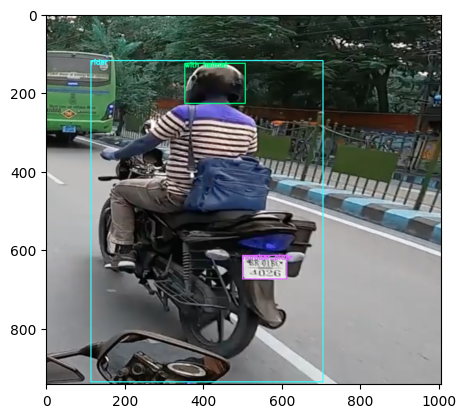

actual image ↓


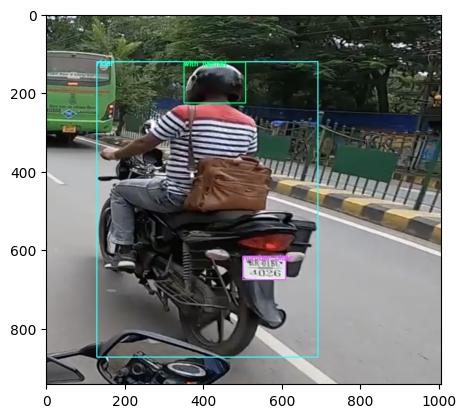

In [ ]:
image_name = 'new94'
print('prediction ↓')
plot_pred_image(image_name=image_name)
print('actual image ↓')
plot_image(image_name=image_name, data_type='val')